# Translating Constraints into QUBOs for the  Quadratic Knapsack Problem
```python

In [300]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit_aer.primitives import Estimator as AerEstimator
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

# QKP problem parameters

In [301]:
# n_items = 7
# weights = [37, 10, 24, 27, 11, 19, 35]
# profits = np.array([[44, 64, 64, 70, 47, 47, 0],
#                     [64, 47, 0, 0, 0, 41, 54],
#                     [64, 0, 1, 11, 12, 8, 15],
#                     [70, 0, 11, 0, 6, 2, 28],
#                     [47, 0, 12, 6, 21, 0, 0],
#                     [47, 41, 8, 2, 0, 46, 15],
#                     [0, 54, 15, 28, 0, 15, 39]])
# capacity = 85
# real_solution = [1, 1, 1, 1, 1, 1, 0]

# total_possible_profit = np.sum(profits) 
# print(f"Total possible profit: {total_possible_profit / 4}")
# penalty_factor = total_possible_profit / 4

# # penalty_factor = total_possible_profit / (total_possible_weight-capacity)**2
# # print(f"Penalty factor: {penalty_factor}")

In [302]:
# n_items = 7
# weights = [25, 5, 22, 16, 1, 26, 34]

# profits = np.array([[45, 0, 61, 0, 0, 58, 0],
#                       [0, 45, 28, 64, 68, 0, 0],
#                       [61, 28, 37, 55, 32, 14, 30],
#                       [0, 64, 55, 24, 4, 52, 30],
#                       [0, 68, 32, 4, 39, 25, 0],
#                       [58, 0, 14, 52, 25, 4, 0],
#                       [0, 0, 30, 30, 0, 0, 19]])
# capacity = 95
# real_solution = [1, 1, 0, 0, 1, 1, 0]
# total_possible_profit = np.sum(profits) 
# print(f"Total possible profit: {total_possible_profit / 4}")
# penalty_factor = total_possible_profit / 4

# # penalty_factor = total_possible_profit / (total_possible_weight-capacity)**2
# # print(f"Penalty factor: {penalty_factor}")

In [303]:
n_items = 7
weights = [12, 32, 10, 18, 18, 4, 4]
profits = np.array([[22, 52, 42, 49, 64, 0, 55],
                      [52, 0, 0, 11, 40, 0, 51],
                      [42, 0, 0, 12, 4, 20, 44],
                      [49, 11, 12, 35, 0, 19, 31],
                      [64, 40, 4, 0, 73, 26, 0],
                      [0, 0, 20, 19, 26, 13, 67],
                      [55, 51, 44, 31, 0, 67, 0]])
capacity = 84
real_solution = np.array([1, 1, 1, 0, 1, 1, 1])

In [304]:
# n_items = 4
# weights = [1, 1, 1, 1]
# profits = np.array([[1, 1, 5, 1],
#                     [1, 7, 3, 0],
#                     [5, 3, 7, 4],
#                     [1, 0, 4, 1]]
#                     )
# capacity = 3
# real_solution = np.array([1, 1, 1, 0])
# total_possible_profit = np.sum(profits) 
# print(f"Total possible profit: {total_possible_profit / 4}")
# penalty_factor = total_possible_profit / 4

# QKP using "Implementing Slack-Free Custom Penalty Function  for QUBO on Gate-Based Quantum Computers" by LEE Xin Wei et al. as a reference.
```python

In [305]:
from collections import defaultdict

def build_qkp_cost_hamiltonian_without_constraint(n_items, profits):
    """
    Build the Hamiltonian qubo to the QKP just including the profits.
    Returns a sparsepauliop to use in qaoa.
    """

    pauli_dict = defaultdict(float)

    # Términos cuadráticos
    for i in range(n_items):
        for j in range(i, n_items):
            pauli_i = ["I"] * n_items
            pauli_i[i] = "Z"
            coeff = - 1/4 * profits[i][j]
            if i == j: 
                pauli_str = "".join(pauli_i)[::-1]
                pauli_dict[pauli_str] = coeff 
            else:
                pauli_j = pauli_i.copy()
                pauli_j[j] = "Z"
                pauli_str = "".join(pauli_j)[::-1]
                pauli_dict[pauli_str] += coeff * 2
        

    # Términos lineales
    for i in range(n_items):
        pauli_i = ["I"] * n_items
        pauli_i[i] = "Z"
        pauli_str = "".join(pauli_i)[::-1] 
        coeff = 0
        for j in range(0, n_items):
            coeff += 1/2 * profits[i][j]
        pauli_dict[pauli_str] += coeff
        
  
    return SparsePauliOp.from_list([(p, coeff) for p, coeff in pauli_dict.items() if abs(coeff) > 1e-8])

cost_hamiltonian = build_qkp_cost_hamiltonian_without_constraint(n_items, profits)
print("Hamiltonian QUBO:", cost_hamiltonian)


Hamiltonian QUBO: SparsePauliOp(['IIIIIIZ', 'IIIIIZZ', 'IIIIZIZ', 'IIIZIIZ', 'IIZIIIZ', 'ZIIIIIZ', 'IIIIIZI', 'IIIZIZI', 'IIZIIZI', 'ZIIIIZI', 'IIIIZII', 'IIIZZII', 'IIZIZII', 'IZIIZII', 'ZIIIZII', 'IIIZIII', 'IZIZIII', 'ZIIZIII', 'IIZIIII', 'IZZIIII', 'IZIIIII', 'ZZIIIII', 'ZIIIIII'],
              coeffs=[136.5 +0.j, -26.  +0.j, -21.  +0.j, -24.5 +0.j, -32.  +0.j, -27.5 +0.j,
  77.  +0.j,  -5.5 +0.j, -20.  +0.j, -25.5 +0.j,  61.  +0.j,  -6.  +0.j,
  -2.  +0.j, -10.  +0.j, -22.  +0.j,  69.75+0.j,  -9.5 +0.j, -15.5 +0.j,
  85.25+0.j, -13.  +0.j,  69.25+0.j, -33.5 +0.j, 124.  +0.j])


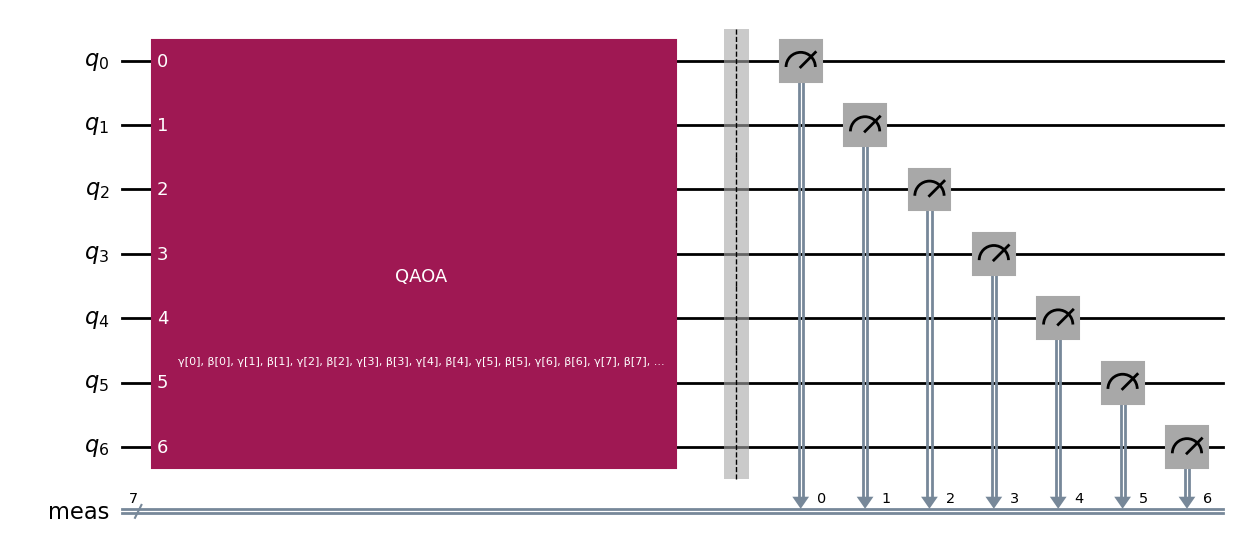

In [306]:
from qiskit.circuit.library import QAOAAnsatz
reps = 40
circuit_cost = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=reps)
circuit_cost.measure_all()
    
circuit_cost.draw('mpl')

In [307]:
def build_qkp_constraint(n_items, weights, capacity):
    """
    Build the Hamiltonian qubo to the QKP just including the constraint.
    Returns a sparsepauliop to use in qaoa.
    """
    pauli_dict = defaultdict(float)

    # Términos lineales
    for i in range(n_items):
        pauli_i = ["I"] * n_items
        pauli_i[i] = "Z"
        pauli_str = "".join(pauli_i)[::-1]
        coeff = -weights[i] / 2
        pauli_dict[pauli_str] = coeff

    # Término lineal de la identidad
    identity_str = "I" * n_items
    coeff = 0
    for i in range(n_items):
        coeff += weights[i] / 2
    coeff -= capacity
    pauli_dict[identity_str] = coeff

    return SparsePauliOp.from_list([(p, coeff) for p, coeff in pauli_dict.items() if abs(coeff) > 1e-8])

constraint_hamiltonian = build_qkp_constraint(n_items, weights, capacity)
print("Hamiltonian Constraint:", constraint_hamiltonian)

Hamiltonian Constraint: SparsePauliOp(['IIIIIIZ', 'IIIIIZI', 'IIIIZII', 'IIIZIII', 'IIZIIII', 'IZIIIII', 'ZIIIIII', 'IIIIIII'],
              coeffs=[ -6.+0.j, -16.+0.j,  -5.+0.j,  -9.+0.j,  -9.+0.j,  -2.+0.j,  -2.+0.j,
 -35.+0.j])


In [308]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta] * reps  

In [309]:
objective_func_vals = []
objective_func_vals_without_constraint = []
objective_func_vals_satisfy = []
objective_func_vals_semi_satisfy = []
constraint_vals = []
constraint_devs = []

estimator = AerEstimator()
estimator.set_options(shots=1000)
iteration_counter = 0

def cost_func_estimator(params, ansatz_cost, cost_hamiltonian, constraint_hamiltonian, estimator):
    global iteration_counter
    
    circuit_bound = ansatz_cost.assign_parameters(params)
    circuits   = [circuit_bound, circuit_bound]
    observables = [cost_hamiltonian, constraint_hamiltonian]
    job = estimator.run(circuits, observables)
    cost, constraint = job.result().values
    variance = job.result().metadata[1]['variance']
    std_dev = np.sqrt(variance)
    objective_func_vals_without_constraint.append( cost)
    constraint_vals.append(constraint)
    constraint_devs.append(std_dev)
    #print("Constraint:", constraint, "Std Dev:", std_dev)

    weight = 2 * std_dev
    penalty_factor = np.abs(cost)**2
    # print("cost", cost)
    if constraint > 0:
        cost += penalty_factor 
        
        if constraint - std_dev > 0:
            cost += penalty_factor
            # print("Penalty factor for 0:", penalty_factor)

        else:   
            violated_fraction = (weight - np.abs(constraint - std_dev)) / weight 
            penalty_factor = penalty_factor * violated_fraction
            # print("Penalty factor for 1:", violated_fraction)
            cost += penalty_factor
            
    if constraint < 0:
        
        cost -= penalty_factor
        
        if constraint + std_dev > 0:
            violated_fraction =  np.abs(constraint + std_dev) / weight
            # penalty_factor = penalty_factor * violated_fraction
            cost -= penalty_factor
            # print("Penalty factor for 2 apply:", violated_fraction)
            objective_func_vals_semi_satisfy.append((iteration_counter, cost))
             
        else:
            cost -= penalty_factor
            # print("Penalty factor for 3 apply:", penalty_factor_past * 0.5)
            objective_func_vals_satisfy.append((iteration_counter, cost))
            
    objective_func_vals.append(cost)
    iteration_counter += 1
    # print("Objective function value:", cost)
    return cost 

result = minimize(
    cost_func_estimator,
    init_params,
    args=(circuit_cost, cost_hamiltonian, constraint_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-10,
    options={'maxiter': 5000}
)

print("Optimization Result:\n", result)

Optimization Result:
  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -171058.55923199994
       x: [ 4.394e+00  1.574e+00 ...  3.138e+00  1.596e+00]
    nfev: 1483
   maxcv: 0.0


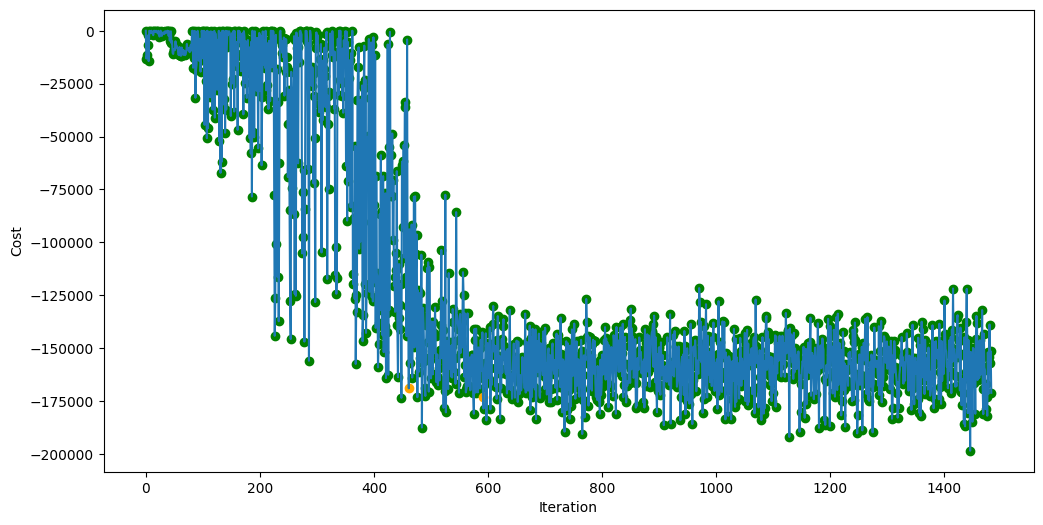

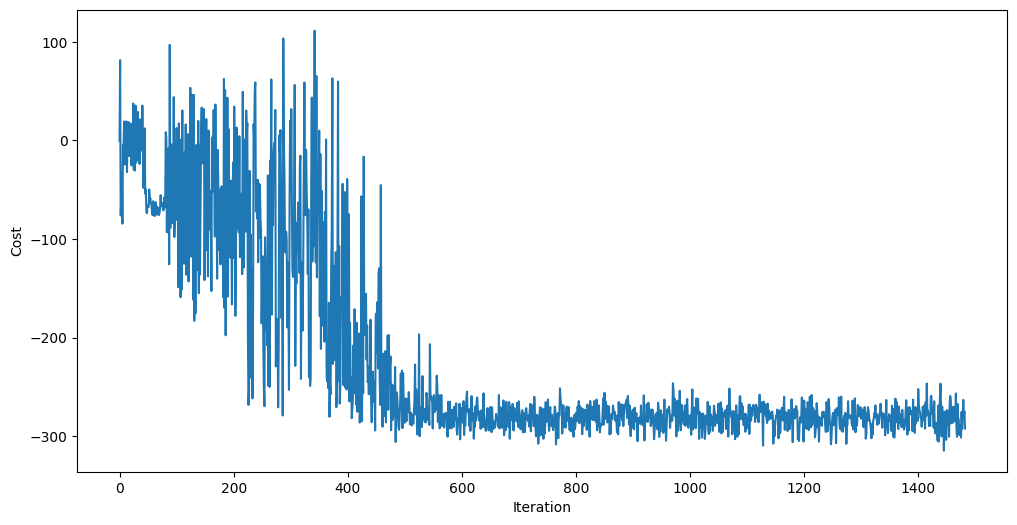

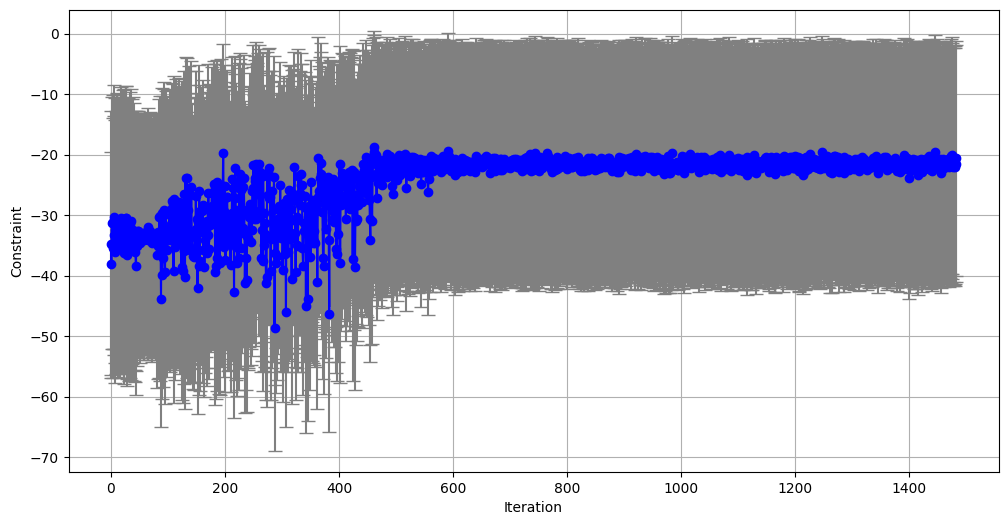

In [310]:
import matplotlib.pyplot as plt
iters_satisfy, vals_satisfy = zip(*objective_func_vals_satisfy)
iters_semi_satisfy, vals_semi_satisfy = zip(*objective_func_vals_semi_satisfy)

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.scatter(iters_satisfy, vals_satisfy, color='green',label='Satisfy Constraint')
plt.scatter(iters_semi_satisfy, vals_semi_satisfy, color='orange', label='Semi Satisfy Constraint')
plt.xlabel("Iteration")
plt.ylabel("Cost")

plt.show()
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals_without_constraint)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

plt.figure(figsize=(12, 6))
x = np.arange(len(constraint_vals))
plt.errorbar(x, constraint_vals, yerr=constraint_devs, fmt='-o', capsize=5, color='blue', ecolor='gray')
plt.xlabel("Iteration")
plt.ylabel("Constraint")
plt.grid(True)
plt.show()
optimized_circuit = circuit_cost.assign_parameters(result.x)
# optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [311]:
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram


# Transpilar para el simulador
simulator = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(optimized_circuit, simulator)

# Ejecutar el circuito
shots = 10_000
job = simulator.run(transpiled_circuit, backend=simulator, shots=shots)
result = job.result()

# Obtener conteos
counts = result.get_counts()

# Normalizar los resultados
final_distribution = {key: val/shots for key, val in counts.items()}



In [312]:
import numpy as np

def evaluate_solution(bitstring, n_items, weights, profits, capacity):
    if len(bitstring) != n_items:
        bitstring = bitstring[:n_items]

    total_weight = sum(weights[i] for i in range(len(bitstring)) if bitstring[i] == 1)
    total_profit = sum(profits[i][j] * bitstring[i] * bitstring[j] for i in range(len(bitstring)) for j in range(len(bitstring)))
    
    return total_profit, total_weight <= capacity


keys = list(final_distribution.keys())
values = list(final_distribution.values())

# Obtain the top 4 bitstrings with highest probabilities and evaluate them

top_indices = np.argsort(values)[-4:][::-1]
best_valid = None
best_valid_profit = None
best_valid_bitstring = None

for idx in top_indices:
    bitstring = keys[idx]
    prob = values[idx]
    bitstring_list = [int(d) for d in bitstring]
    total_profit, is_valid = evaluate_solution(bitstring_list, n_items, weights, profits, capacity)
    print(f"Solution: {bitstring_list}, Probabilidad: {prob}, Profit: {total_profit}, Valid: {is_valid}")
    if is_valid:
        if best_valid is None or total_profit > best_valid_profit:
            best_valid = (bitstring, prob, bitstring_list, total_profit)
            best_valid_profit = total_profit

if best_valid is not None:
    print("\nBest valid solution found:")
    print(f"Solution: {best_valid[0]}, Probability: {best_valid[1]}, Profit: {best_valid[3]}")

else:
    # If none is valid, it returns the most likely
    idx = np.argmax(values)
    bitstring = keys[idx]
    prob = values[idx]
    bitstring_list = [int(d) for d in bitstring]
    total_profit, is_valid = evaluate_solution(bitstring_list, n_items, weights, profits, capacity)
    print("\nNo valid solution found. Showing the most likely:")
    print(f"Bitstring: {bitstring}, Probability: {prob}, Como lista: {bitstring_list}, Profit: {total_profit}, Valid: {is_valid}")

Solution: [1, 1, 1, 0, 1, 1, 1], Probabilidad: 0.2574, Profit: 1038, Valid: True
Solution: [1, 1, 1, 1, 0, 1, 1], Probabilidad: 0.0694, Profit: 976, Valid: True
Solution: [1, 1, 1, 0, 0, 0, 0], Probabilidad: 0.0585, Profit: 210, Valid: True
Solution: [1, 1, 1, 0, 0, 1, 1], Probabilidad: 0.0422, Profit: 697, Valid: True

Best valid solution found:
Solution: 1110111, Probability: 0.2574, Profit: 1038


In [313]:
total_profit, is_valid = evaluate_solution(real_solution, n_items, weights, profits, capacity)
print(f"Real solution: {real_solution}, Profit: {total_profit}, Valid: {is_valid}")


Real solution: [1 1 1 0 1 1 1], Profit: 1038, Valid: True
